RMSE in Linear Regression  
y_pred - y_true 차이 값을 구해서 제곱 루트 평균, y_pred = XW

Cross Entropy in Logistic Regression  
y가 0 혹은 1인 경우 sigmoid에 넣어서 1/(1+tf.exp(-1*(W*x+b)))

Cross Entropy in Multiclass Logistic Regression(MLP, CNN)  
class의 개수가 여러개인 경우  

ylog(y_hat) + (1-y)log(1-log(y_hat))  

GAN에서 activation에 함수 안쓸 경우 => loss에 binaryclassification, from_logits=True

**내장함수 사용 : tf.nn.sparse_softmax_cross_entropy_with_logits  
확률값을 넣지말고 아직 softmax를 거치지 않은 logits을 파라미터로 넣어야함  
Training시에는 softmax를 거치지 않고 test시에만 거치겠다.  
logits = Unnormalized log-probabilites  

### Lecture3: Linear Regression & Gradient Descent

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.boston_housing.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#Normalization
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

(404, 13)
(404,)
(102, 13)
(102,)


In [3]:
dim_target = 12 # 0~12 사이의 숫자 

# X_train_1D = X_train[:,dim_target]
# X_test_1D = X_test[:,dim_target]
# print(X_train_1D.shape)
# print(X_test_1D.shape)

# matrix multiplication을 위해서 차원을 변경
X_train_1D = tf.expand_dims(X_train[:,dim_target],1)
X_test_1D = tf.expand_dims(X_test[:,dim_target],1)
print(X_train_1D.shape)
print(X_test_1D.shape)

(404, 1)
(102, 1)


In [4]:
def plot_graph(X, Y, X_hat=None, Y_hat=None, str_title=None):
    fig = plt.figure(figsize=(8,6))
    
    if str_title is not None:
        plt.title(str_title, fontsize=20, pad=20)
        
    plt.plot(X, Y, ls='none', marker='o')
    if X_hat is not None and Y_hat is not None:
        plt.plot(X_hat, Y_hat)
        
    plt.tick_params(axis='both', labelsize=14)

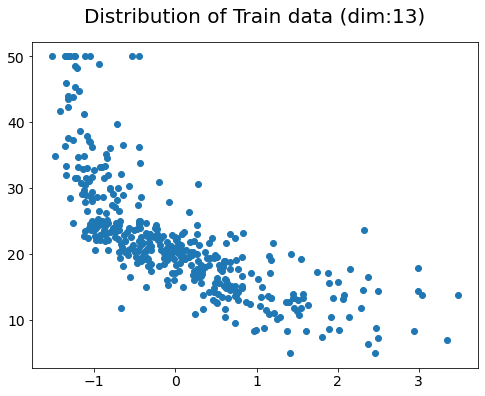

In [5]:
plot_graph(X_train_1D, Y_train, str_title = 'Distribution of Train data (dim:{})'.format(dim_target+1))

In [6]:
# W = (X.T @ X).I @ X.T @ y

Xmat_T_Xmat = tf.matmul(tf.transpose(X_train_1D), X_train_1D)
weight = tf.matmul(
            tf.matmul(
                tf.linalg.inv(Xmat_T_Xmat),
                tf.transpose(X_train_1D)
            ), tf.expand_dims(Y_train,1))
print(weight)

tf.Tensor([[-6.72258852]], shape=(1, 1), dtype=float64)


In [7]:
#RMSE (Root Mean Square Error)
loss = tf.sqrt(tf.reduce_mean((Y_test - tf.squeeze(tf.matmul(X_test_1D,weight)))**2)).numpy()
print(loss)

23.4293024538165


In [8]:
a = tf.constant([1, 2, 3])
b = tf.expand_dims([4, 5, 6], 1)
print(a.shape)
print(b.shape)

print(a+b)

(3,)
(3, 1)
tf.Tensor(
[[5 6 7]
 [6 7 8]
 [7 8 9]], shape=(3, 3), dtype=int32)


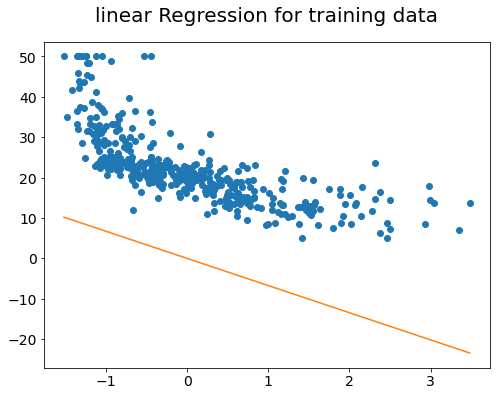

In [9]:
X_train_for_line = np.expand_dims(np.linspace(np.min(X_train_1D), np.max(X_train_1D), 100),1)

plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(X_train_for_line, weight),
          str_title = 'linear Regression for training data')

In [17]:
def feature_f(X, degree):
    num_X = tf.shape(X)[0]
    Phi = tf.ones([num_X, 1], dtype=tf.dtypes.double)
    
    for i in range(0, degree):
        Phi = Phi * X
        if i == degree-1:
            Phi = tf.concat([feature_f(X, degree-1), Phi], axis=1)
    return Phi

In [18]:
k = 3

Phi_train = feature_f(X_train_1D, k)
Phi_test = feature_f(X_test_1D, k)
Phi_Xtrain_for_line = feature_f(X_train_for_line, k)

Phi_T_Phi = tf.matmul(tf.transpose(Phi_train),Phi_train)
weight_f = tf.matmul(
            tf.matmul(
                tf.linalg.inv(Phi_T_Phi),
                tf.transpose(Phi_train)
            ), tf.expand_dims(Y_train,1))

loss = tf.sqrt(tf.reduce_mean((Y_test - tf.squeeze(tf.matmul(Phi_test,weight_f)))**2)).numpy()
print(loss)

5.68388844400261


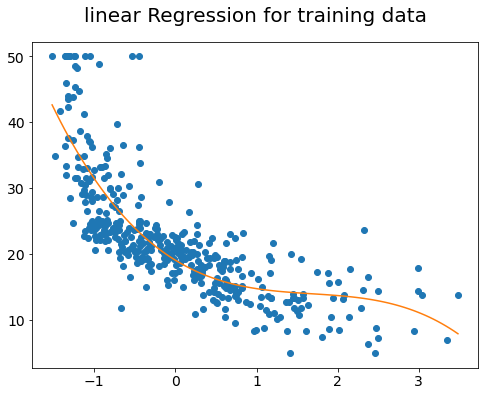

In [12]:
plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(Phi_Xtrain_for_line, weight_f),
          str_title = 'linear Regression for training data')

### Gradient Descent

In [21]:
#weight_gd = tf.Variable(tf.random_normal_initializer(steddev=1)(weight_f.shape)) 
# tf.random_normal_initializer는 float32로 고정되어 있어 불편함

(H,W) = weight_f.shape
weight_gd = tf.Variable(np.random.randn(H,W), dtype=tf.dtypes.float64)

def RMSE(y_pred, y_true):
    return tf.math.sqrt(tf.reduce_mean(tf.square(tf.squeeze(y_pred) - y_true))) # L(loss)

In [22]:
learning_rate = 0.001
optimizer = tf.optimizers.SGD(learning_rate)

def run_optimization():
    with tf.GradientTape() as g:   # loss를 계산하는 과정이 기록됨
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        
    gradients = g.gradient(loss, [weight_gd])   # g.gradient = GradientTape에 있는 메소드
                                                # loss가 작아지도록 만드는 weight를 찾아야하기 때문에 dL/dW를 통해서 계산
    optimizer.apply_gradients(zip(gradients,[weight_gd])) # apply_gradients = W - learning rate*(dL/dW)
                                                           # 계산된 gradient를 통해 weight를 update시켜줌

In [23]:
training_steps = 30000
display_step = 5000
for step in range(training_steps):
    run_optimization()
    
    if step % display_step == 0:
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        print("step: ",step, ", loss: ",loss.numpy())
        print("weight: ", weight_gd.numpy())

step:  0 , loss:  22.117004180928927
weight:  [[ 0.78673531]
 [-2.46202157]
 [ 1.37255982]
 [-0.87957039]]
step:  5000 , loss:  14.55995858595389
weight:  [[ 5.37126441]
 [-3.72137073]
 [ 4.96261903]
 [-1.01790778]]
step:  10000 , loss:  9.340788452541757
weight:  [[ 9.56203574]
 [-4.91714682]
 [ 7.44622094]
 [-1.89506028]]
step:  15000 , loss:  6.982517037938487
weight:  [[12.65984499]
 [-5.66050305]
 [ 8.46913248]
 [-2.28708469]]
step:  20000 , loss:  6.278493615948527
weight:  [[14.45284716]
 [-5.9930381 ]
 [ 8.2591257 ]
 [-2.25416303]]
step:  25000 , loss:  5.944973961250356
weight:  [[15.54183454]
 [-6.17632457]
 [ 7.63205366]
 [-2.06588047]]


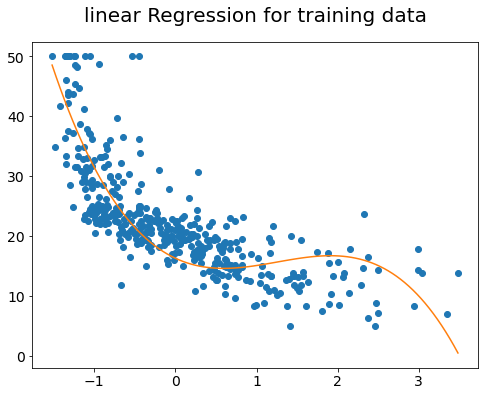

In [24]:
plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(Phi_Xtrain_for_line, weight_gd),
          str_title = 'linear Regression for training data')

In [25]:
pred = tf.matmul(Phi_test, weight_gd)
loss = RMSE(pred, Y_test)

In [26]:
print(loss)

tf.Tensor(6.432978951923473, shape=(), dtype=float64)
